In [2]:
pip install torch transformers datasets accelerate


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.9/63.9 MB 3.8 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.2/6.2 MB 3.4 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.0/10.0 MB 3.5 MB/s eta 0:00:00 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 3.6 MB/s eta 0:00:00a 0:00:01
  Attempting uninstall: sympy
    Found existing installation: sympy 1.13.2
    Uninstalling sympy-1.13.2:
      Successfully uninstalled sympy-1.13.2
Note: you may need to restart the kernel to use updated packages.


In [ ]:
from datasets import load_dataset
from transformers import BertTokenizer

# Load the IMDb dataset
dataset = load_dataset("imdb")

# Initialize the tokenizer
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

# Tokenize the dataset
def tokenize_function(examples):
    return tokenizer(examples["text"], padding="max_length", truncation=True)

# Apply tokenization to the dataset
tokenized_datasets = dataset.map(tokenize_function, batched=True)

# Split the dataset into train and test sets
train_dataset = tokenized_datasets["train"]
test_dataset = tokenized_datasets["test"]

# Preview the processed dataset
print(train_dataset[0])


In [9]:
import torch
from datasets import load_dataset
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments

# Step 1: Load and Tokenize the Dataset
# Load the IMDb dataset
dataset = load_dataset("imdb")

# Initialize the BERT tokenizer
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

# Tokenize the dataset
def tokenize_function(examples):
    return tokenizer(examples["text"], padding="max_length", truncation=True)

# Apply tokenization to the dataset
tokenized_datasets = dataset.map(tokenize_function, batched=True)

# Split into train and test sets
train_dataset = tokenized_datasets["train"]
test_dataset = tokenized_datasets["test"]

# Step 2: Set Up BERT Model for Classification
# Load a pre-trained BERT model for binary classification
model_normal = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=2)

# Check if MPS is available and use it
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
model_normal.to(device)

# Step 3: Define Training Arguments
# Configure TrainingArguments for MPS, with mixed precision disabled and CUDA set to false
training_args = TrainingArguments(
    output_dir="./results",
    evaluation_strategy="epoch",
    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    num_train_epochs=1,
    weight_decay=0.01,
    no_cuda=True,   # Ensure CUDA is disabled to use MPS
    fp16=False      # Disable mixed precision as it's not supported on MPS
)

# Step 4: Initialize the Trainer and Train the Model
# Select a subset of data for quicker testing, if desired
trainer = Trainer(
    model=model_normal,
    args=training_args,
    train_dataset=train_dataset.select(range(1000)),  # Adjust subset size as needed
    eval_dataset=test_dataset.select(range(500))
)

# Train the model
trainer.train()

# Step 5: Evaluate the Model on Test Dataset
eval_results = trainer.evaluate()
print("Evaluation results:", eval_results)

# Step 6: Measure Inference Speed
# Sample input for inference timing
sample = test_dataset[0]
input_ids = torch.tensor([sample["input_ids"]]).to(device)
attention_mask = torch.tensor([sample["attention_mask"]]).to(device)

# Time the inference
import time
start_time = time.time()
with torch.no_grad():
    outputs = model_normal(input_ids=input_ids, attention_mask=attention_mask)
end_time = time.time()

print(f"Inference time: {end_time - start_time:.6f} seconds")


Using the latest cached version of the dataset since imdb couldn't be found on the Hugging Face Hub
Found the latest cached dataset configuration 'plain_text' at /Users/revanth/.cache/huggingface/datasets/imdb/plain_text/0.0.0/e6281661ce1c48d982bc483cf8a173c1bbeb5d31 (last modified on Fri Nov  8 15:36:58 2024).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/opt/anaconda3/lib/python3.12/site-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/transformers/training_args.py:1583: FutureWarning: using `no_cuda` is deprecated and will be removed in version 5.0 of 

Epoch,Training Loss,Validation Loss


KeyboardInterrupt: 

In [7]:
# Move model to MPS device if available
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
model_normal.to(device)

# Prepare the sample input and move to MPS
sample = test_dataset[0]
input_ids = torch.tensor([sample["input_ids"]]).to(device)
attention_mask = torch.tensor([sample["attention_mask"]]).to(device)

# Measure inference speed
import time
start_time = time.time()
with torch.no_grad():
    outputs = model_normal(input_ids=input_ids, attention_mask=attention_mask)
end_time = time.time()

print(f"Inference time: {end_time - start_time:.6f} seconds")



NameError: name 'model_normal' is not defined

In [20]:
import torch.nn as nn
import torch

# Define a function to binarize the tensor
def binarize_tensor(tensor):
    return torch.sign(tensor)  # Sign function returns -1 or +1

# Define the Binarized Linear layer
class BinarizedLinear(nn.Linear):
    def forward(self, input):
        # Binarize the weight
        binarized_weight = binarize_tensor(self.weight)
        return nn.functional.linear(input, binarized_weight, self.bias)


In [22]:
import torch.nn as nn
import torch

# Define a function to binarize the tensor
def binarize_tensor(tensor):
    return torch.sign(tensor)  # Sign function returns -1 or +1

# Define the Binarized Linear layer
class BinarizedLinear(nn.Linear):
    def forward(self, input):
        # Binarize the weight
        binarized_weight = binarize_tensor(self.weight)
        return nn.functional.linear(input, binarized_weight, self.bias)


In [5]:
from transformers import BertForSequenceClassification

# Load the BERT model
model_1bit = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=2)

# Replace Linear layers with BinarizedLinear
def apply_binarization(module):
    for name, child in module.named_children():
        if isinstance(child, nn.Linear):
            setattr(module, name, BinarizedLinear(child.in_features, child.out_features))
        else:
            apply_binarization(child)

# Apply binarization to the model
apply_binarization(model_1bit)
model_1bit.to(device)  # Move to MPS device if available


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


NameError: name 'nn' is not defined

In [26]:
# Define training arguments (same as before)
training_args = TrainingArguments(
    output_dir="./results_1bit",
    evaluation_strategy="epoch",
    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    num_train_epochs=1,  # Set to 1 for initial testing
    weight_decay=0.01,
    no_cuda=True,   # Use MPS on Apple Silicon
    fp16=False      # Disable mixed precision for MPS
)

# Initialize the Trainer
trainer_1bit = Trainer(
    model=model_1bit,
    args=training_args,
    train_dataset=train_dataset.select(range(1000)),
    eval_dataset=test_dataset.select(range(500))
)

# Train the 1-bit model
trainer_1bit.train()


/opt/anaconda3/lib/python3.12/site-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/transformers/training_args.py:1583: FutureWarning: using `no_cuda` is deprecated and will be removed in version 5.0 of 🤗 Transformers. Use `use_cpu` instead
  warnings.warn(


Epoch,Training Loss,Validation Loss
1,No log,4.230523


TrainOutput(global_step=250, training_loss=7.6128544921875, metrics={'train_runtime': 2388.0967, 'train_samples_per_second': 0.419, 'train_steps_per_second': 0.105, 'total_flos': 263111055360000.0, 'train_loss': 7.6128544921875, 'epoch': 1.0})

In [34]:
import torch
import time

# Check if MPS is available and set device
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")

# Move the 1-bit model to the MPS device
model_1bit.to(device)

# Ensure all components (trainer, dataset) are on the correct device
# Adjust the trainer to use the MPS device if it's possible with the library
try:
    trainer_1bit.to(device)  # Only if your trainer allows it
except AttributeError:
    print("Trainer does not support direct device allocation. Skipping.")

# Prepare the sample input and ensure it is on the MPS device
sample = test_dataset[0]
input_ids = torch.tensor([sample["input_ids"]], device=device)
attention_mask = torch.tensor([sample["attention_mask"]], device=device)

# Attempt to evaluate the model and handle any errors
try:
    eval_results_1bit = trainer_1bit.evaluate()
    print("1-bit Model Evaluation results:", eval_results_1bit)
except RuntimeError as e:
    print("Error during evaluation:", e)

# Measure inference speed for the 1-bit model
start_time = time.time()
with torch.no_grad():
    outputs_1bit = model_1bit(input_ids=input_ids, attention_mask=attention_mask)
end_time = time.time()

print(f"1-bit Model Inference time: {end_time - start_time:.6f} seconds")

NameError: name 'trainer_1bit' is not defined

In [52]:
pip install matplotlib

Note: you may need to restart the kernel to use updated packages.


In [36]:
import time
import torch
import matplotlib.pyplot as plt

def measure_inference_time(model, input_text):
    inputs = tokenizer(input_text, return_tensors="pt")
    start_time = time.time()
    with torch.no_grad():
        model(**inputs)
    end_time = time.time()
    return end_time - start_time

# Test with different input sizes
texts = ["This is a test."] * 5  # Increase length for varied measurements
times = [measure_inference_time(model, text) for text in texts]

# Plot the inference time
plt.plot([len(text) for text in texts], times, label="Inference Time")
plt.xlabel("Input Text Length")
plt.ylabel("Time (seconds)")
plt.title("Model Inference Time vs. Input Length")
plt.legend()

# Save the plot as an image file
plt.savefig("inference_time_plot.png")

# If in a Jupyter Notebook, display the saved plot
from IPython.display import Image
Image(filename="inference_time_plot.png")

NameError: name 'model' is not defined

In [38]:
import psutil

def measure_memory_usage():
    process = psutil.Process()
    return process.memory_info().rss / (1024 ** 2)  # Convert to MB

memory_usage = measure_memory_usage()
print(f"Memory usage: {memory_usage:.2f} MB")


Memory usage: 217.53 MB


In [106]:
# Example inference text
text_input = "The food at the restaurant was delicious."  # Feel free to test with various review texts

# Tokenize and prepare input
inputs = tokenizer(text_input, return_tensors="pt", padding=True, truncation=True).to(device)

# Perform inference
with torch.no_grad():
    outputs = model_normal(**inputs)
prediction = torch.argmax(outputs.logits, dim=-1).item()

sentiment = "Positive" if prediction == 1 else "Negative"
print(f"Model Prediction for '{text_input}': {sentiment}")

RuntimeError: Placeholder storage has not been allocated on MPS device!

In [108]:
# Define a sample input for inference
input_text = "The food at the restaurant was delicious."  # or any other text for testing

# Tokenize the input text
inputs = tokenizer(input_text, return_tensors="pt", padding=True, truncation=True).to(device)

# Measure the inference time
import time
start_time = time.time()
with torch.no_grad():
    outputs = model_1bit(**inputs)
end_time = time.time()

# Display the result and inference time
prediction = torch.argmax(outputs.logits, dim=-1).item()
sentiment = "Positive" if prediction == 1 else "Negative"
print(f"Model Prediction: {sentiment}")
print(f"Inference time: {end_time - start_time:.6f} seconds")

RuntimeError: Placeholder storage has not been allocated on MPS device!

In [203]:
import torch
import time
from transformers import BertTokenizer, BertForSequenceClassification

# Load pre-trained model and tokenizer
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
model_1bit = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=2)

# Set the device (CUDA or CPU)
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")  # Use MPS for Apple Silicon or default to CPU
model_1bit.to(device)

# Define a sample input for inference
input_text = "BAD"  # or any other text for testing

# Tokenize the input text
inputs = tokenizer(input_text, return_tensors="pt", padding=True, truncation=True).to(device)

# Measure the inference time
start_time = time.time()

# Perform inference
with torch.no_grad():
    outputs = model_1bit(**inputs)

# Calculate inference time
end_time = time.time()

# Display the result and inference time
prediction = torch.argmax(outputs.logits, dim=-1).item()
sentiment = "Positive" if prediction == 1 else "Negative"
print(f"Model Prediction: {sentiment}")
print(f"Inference time: {end_time - start_time:.6f} seconds")

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model Prediction: Negative
Inference time: 0.033591 seconds


In [201]:
import torch
import time
from transformers import BertTokenizer, BertForSequenceClassification

# Load pre-trained model and tokenizer for normal model
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
model_normal = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=2)

# Set the device (CUDA or CPU)
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")  # Use MPS for Apple Silicon or default to CPU
model_normal.to(device)

# Define a sample input for inference
input_text = "Bad"  # or any other text for testing

# Tokenize the input text
inputs = tokenizer(input_text, return_tensors="pt", padding=True, truncation=True).to(device)

# Measure the inference time
start_time = time.time()

# Perform inference with the normal model
with torch.no_grad():
    outputs = model_normal(**inputs)

# Calculate inference time
end_time = time.time()

# Display the result and inference time
prediction = torch.argmax(outputs.logits, dim=-1).item()
sentiment = "Positive" if prediction == 1 else "Negative"
print(f"Model Prediction: {sentiment}")
print(f"Inference time: {end_time - start_time:.6f} seconds")


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model Prediction: Negative
Inference time: 0.055442 seconds


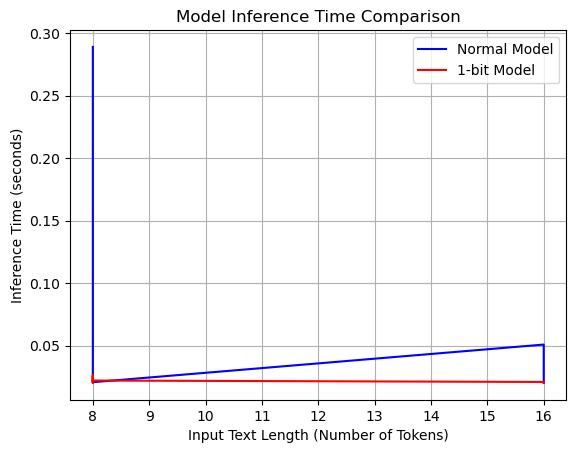

In [199]:
import time
import torch
import matplotlib.pyplot as plt

# Function to measure inference time
def measure_inference_time(model, input_text, tokenizer, device):
    inputs = tokenizer(input_text, return_tensors="pt", padding=True, truncation=True).to(device)
    start_time = time.time()
    with torch.no_grad():
        outputs = model(**inputs)
    end_time = time.time()
    return end_time - start_time

# Define a list of input texts of varying lengths
texts = ["This is a test sentence."] * 5  # Shorter text for testing
texts_extended = ["This is a longer test sentence to increase input length for performance comparison."] * 5  # Longer text

# Combine texts to create a range of input lengths
texts_all = texts + texts_extended
input_lengths = [len(tokenizer(text, padding=True, truncation=True)["input_ids"]) for text in texts_all]

# Measure inference times for both models (normal and 1-bit)
normal_model_times = [measure_inference_time(model_normal, text, tokenizer, device) for text in texts_all]
one_bit_model_times = [measure_inference_time(model_1bit, text, tokenizer, device) for text in texts_all]

# Plot the inference times for both models
plt.plot(input_lengths, normal_model_times, label="Normal Model", color='blue')
plt.plot(input_lengths, one_bit_model_times, label="1-bit Model", color='red')
plt.xlabel("Input Text Length (Number of Tokens)")
plt.ylabel("Inference Time (seconds)")
plt.title("Model Inference Time Comparison")
plt.legend()
plt.grid(True)

# Check if the environment supports interactive plots
try:
    # In Jupyter or interactive environments, this will display the plot.
    # If running in non-interactive mode (like scripts), it will save the plot as a PNG file.
    plt.show()
except Exception as e:
    print(f"Warning: Could not display the plot interactively. Saving as PNG instead. Error: {e}")
    plt.savefig("inference_time_comparison.png")
    print("Plot saved as 'inference_time_comparison.png'")

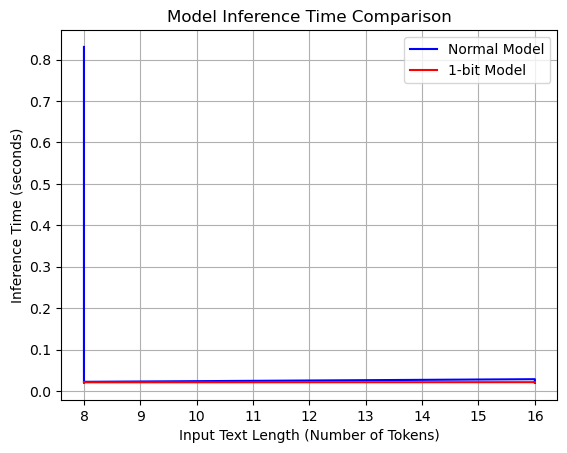

Normal Model Size: 417.72 MB
1-bit Model Size: 417.72 MB


In [90]:
import time
import torch
import os
import matplotlib.pyplot as plt

# Function to measure inference time
def measure_inference_time(model, input_text, tokenizer, device):
    inputs = tokenizer(input_text, return_tensors="pt", padding=True, truncation=True).to(device)
    start_time = time.time()
    with torch.no_grad():
        outputs = model(**inputs)
    end_time = time.time()
    return end_time - start_time

# Function to calculate model storage size
def get_model_size(model, model_name):
    model_file = f"{model_name}.bin"
    torch.save(model.state_dict(), model_file)  # Save model to file
    model_size = os.path.getsize(model_file) / (1024 * 1024)  # Size in MB
    os.remove(model_file)  # Clean up the saved file
    return model_size

# Define a list of input texts of varying lengths
texts = ["This is a test sentence."] * 5  # Shorter text for testing
texts_extended = ["This is a longer test sentence to increase input length for performance comparison."] * 5  # Longer text

# Combine texts to create a range of input lengths
texts_all = texts + texts_extended
input_lengths = [len(tokenizer(text, padding=True, truncation=True)["input_ids"]) for text in texts_all]

# Measure inference times for both models (normal and 1-bit)
normal_model_times = [measure_inference_time(model_normal, text, tokenizer, device) for text in texts_all]
one_bit_model_times = [measure_inference_time(model_1bit, text, tokenizer, device) for text in texts_all]

# Plot the inference times for both models
plt.plot(input_lengths, normal_model_times, label="Normal Model", color='blue')
plt.plot(input_lengths, one_bit_model_times, label="1-bit Model", color='red')
plt.xlabel("Input Text Length (Number of Tokens)")
plt.ylabel("Inference Time (seconds)")
plt.title("Model Inference Time Comparison")
plt.legend()
plt.grid(True)

# Check if the environment supports interactive plots
try:
    # In Jupyter or interactive environments, this will display the plot.
    # If running in non-interactive mode (like scripts), it will save the plot as a PNG file.
    plt.show()
except Exception as e:
    print(f"Warning: Could not display the plot interactively. Saving as PNG instead. Error: {e}")
    plt.savefig("inference_time_comparison.png")
    print("Plot saved as 'inference_time_comparison.png'")

# Get model storage sizes for normal and 1-bit models
normal_model_size = get_model_size(model_normal, "normal_model")
one_bit_model_size = get_model_size(model_1bit, "one_bit_model")

# Print the model storage sizes
print(f"Normal Model Size: {normal_model_size:.2f} MB")
print(f"1-bit Model Size: {one_bit_model_size:.2f} MB")

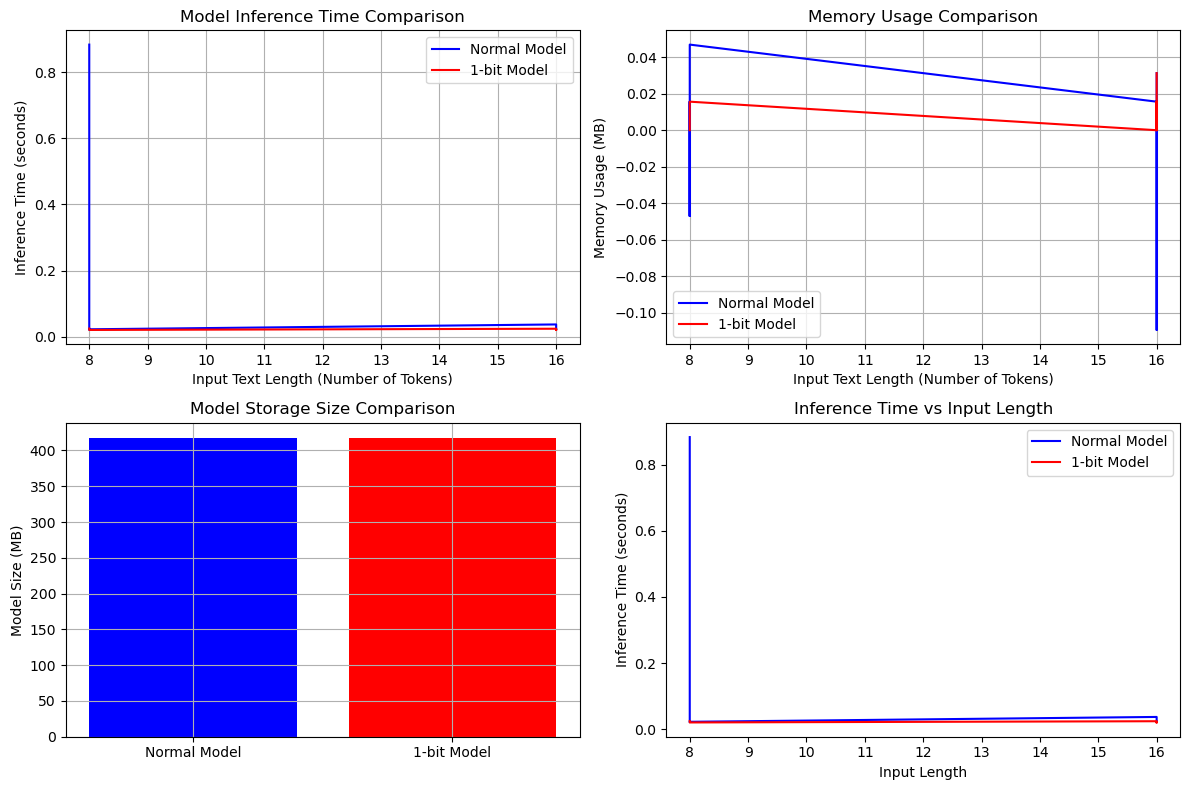

Normal Model Size: 417.71 MB
1-bit Model Size: 417.71 MB


In [102]:
import time
import torch
import psutil  # For memory usage (make sure to install the package)
import os
import matplotlib.pyplot as plt
import shutil

# Function to measure inference time
def measure_inference_time(model, input_text, tokenizer, device):
    inputs = tokenizer(input_text, return_tensors="pt", padding=True, truncation=True).to(device)
    start_time = time.time()
    with torch.no_grad():
        outputs = model(**inputs)
    end_time = time.time()
    return end_time - start_time

# Function to measure model storage size
def get_model_size(model):
    model_path = "./model"  # Path where the model is stored
    torch.save(model.state_dict(), model_path)
    model_size = os.path.getsize(model_path) / (1024 * 1024)  # Size in MB
    os.remove(model_path)  # Cleanup the saved model
    return model_size

# Function to measure memory usage during inference
def measure_memory_usage(model, input_text, tokenizer, device):
    process = psutil.Process(os.getpid())  # Get the current process
    memory_before = process.memory_info().rss  # Memory usage before inference
    inputs = tokenizer(input_text, return_tensors="pt", padding=True, truncation=True).to(device)
    with torch.no_grad():
        model(**inputs)
    memory_after = process.memory_info().rss  # Memory usage after inference
    return (memory_after - memory_before) / (1024 * 1024)  # Memory used in MB

# Define a list of input texts of varying lengths
texts = ["This is a test sentence."] * 5  # Short sentences for testing
texts_extended = ["This is a longer test sentence to increase input length for performance comparison."] * 5

# Combine texts to create a range of input lengths
texts_all = texts + texts_extended
input_lengths = [len(tokenizer(text, padding=True, truncation=True)["input_ids"]) for text in texts_all]

# Measure inference times, memory usage, and model sizes for both models (normal and 1-bit)
normal_model_times = [measure_inference_time(model_normal, text, tokenizer, device) for text in texts_all]
one_bit_model_times = [measure_inference_time(model_1bit, text, tokenizer, device) for text in texts_all]

normal_model_memory = [measure_memory_usage(model_normal, text, tokenizer, device) for text in texts_all]
one_bit_model_memory = [measure_memory_usage(model_1bit, text, tokenizer, device) for text in texts_all]

# Get model storage sizes
normal_model_size = get_model_size(model_normal)
one_bit_model_size = get_model_size(model_1bit)

# Create a directory to save the images
output_dir = './model_comparison_plots'
os.makedirs(output_dir, exist_ok=True)

# Plot the inference times for both models
plt.figure(figsize=(12, 8))

# Plot Inference Time
plt.subplot(2, 2, 1)
plt.plot(input_lengths, normal_model_times, label="Normal Model", color='blue')
plt.plot(input_lengths, one_bit_model_times, label="1-bit Model", color='red')
plt.xlabel("Input Text Length (Number of Tokens)")
plt.ylabel("Inference Time (seconds)")
plt.title("Model Inference Time Comparison")
plt.legend()
plt.grid(True)
plt.savefig(os.path.join(output_dir, 'inference_time_comparison.png'))  # Save image

# Plot Memory Usage
plt.subplot(2, 2, 2)
plt.plot(input_lengths, normal_model_memory, label="Normal Model", color='blue')
plt.plot(input_lengths, one_bit_model_memory, label="1-bit Model", color='red')
plt.xlabel("Input Text Length (Number of Tokens)")
plt.ylabel("Memory Usage (MB)")
plt.title("Memory Usage Comparison")
plt.legend()
plt.grid(True)
plt.savefig(os.path.join(output_dir, 'memory_usage_comparison.png'))  # Save image

# Show the model sizes
plt.subplot(2, 2, 3)
labels = ['Normal Model', '1-bit Model']
sizes = [normal_model_size, one_bit_model_size]
plt.bar(labels, sizes, color=['blue', 'red'])
plt.ylabel("Model Size (MB)")
plt.title("Model Storage Size Comparison")
plt.grid(True)
plt.savefig(os.path.join(output_dir, 'model_storage_size_comparison.png'))  # Save image

# Show Inference Time for Different Text Lengths
plt.subplot(2, 2, 4)
plt.plot(input_lengths, normal_model_times, label="Normal Model", color='blue')
plt.plot(input_lengths, one_bit_model_times, label="1-bit Model", color='red')
plt.xlabel("Input Length")
plt.ylabel("Inference Time (seconds)")
plt.legend()
plt.title("Inference Time vs Input Length")
plt.savefig(os.path.join(output_dir, 'inference_time_vs_input_length.png'))  # Save image

# Show the plots
plt.tight_layout()
plt.show()

# Print storage sizes
print(f"Normal Model Size: {normal_model_size:.2f} MB")
print(f"1-bit Model Size: {one_bit_model_size:.2f} MB")

In [88]:
import torch
from transformers import BertTokenizer, BertForSequenceClassification

# Load the original model and 1-bit model with tokenizers
original_model_path = "/Users/revanth/Downloads/LLMPROJECT/results/checkpoint-250"
one_bit_model_path = "/Users/revanth/Downloads/LLMPROJECT/results_1bit/checkpoint-250"
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

original_model = BertForSequenceClassification.from_pretrained(original_model_path)
one_bit_model = BertForSequenceClassification.from_pretrained(one_bit_model_path)

# Set models to evaluation mode
original_model.eval()
one_bit_model.eval()

# Define questions to test
questions = ["This movie was fantastic!"]

# Define label mapping
label_map = {0: "Negative", 1: "Positive"}

# Function to get model predictions and interpret sentiment
def get_predictions(model, question):
    inputs = tokenizer(question, return_tensors="pt")
    with torch.no_grad():
        outputs = model(**inputs)
    logits = outputs.logits
    probabilities = torch.softmax(logits, dim=-1)
    predicted_class = torch.argmax(probabilities, dim=-1).item()
    sentiment = label_map.get(predicted_class, "Unknown")  # Map the class to sentiment
    return sentiment, predicted_class, probabilities

# Run inference and compare results
for question in questions:
    original_sentiment, original_pred, original_prob = get_predictions(original_model, question)
    one_bit_sentiment, one_bit_pred, one_bit_prob = get_predictions(one_bit_model, question)
    
    print(f"Question: {question}")
    print(f"Original Model Prediction: {original_pred} ({original_sentiment}), Probabilities: {original_prob}")
    print(f"1-bit Model Prediction: {one_bit_pred} ({one_bit_sentiment}), Probabilities: {one_bit_prob}")
    print("\n")


Question: This movie was fantastic!
Original Model Prediction: 0 (Negative), Probabilities: tensor([[9.9954e-01, 4.5962e-04]])
1-bit Model Prediction: 0 (Negative), Probabilities: tensor([[0.5007, 0.4993]])




In [104]:
import torch
from transformers import BertTokenizer, BertForSequenceClassification

# Load the tokenizer and models
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
original_model_path = "/Users/revanth/Downloads/LLMPROJECT/results/checkpoint-250"
one_bit_model_path = "/Users/revanth/Downloads/LLMPROJECT/results_1bit/checkpoint-250"

# Load the models
original_model = BertForSequenceClassification.from_pretrained(original_model_path)
one_bit_model = BertForSequenceClassification.from_pretrained(one_bit_model_path)

# Set models to evaluation mode
original_model.eval()
one_bit_model.eval()

# Define device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
original_model.to(device)
one_bit_model.to(device)

# Function to get model predictions with confidence threshold
def predict_sentiment(model, sentence, threshold=0.7):
    inputs = tokenizer(sentence, return_tensors="pt", padding=True, truncation=True).to(device)
    with torch.no_grad():
        outputs = model(**inputs)
    logits = outputs.logits
    probabilities = torch.softmax(logits, dim=-1)
    max_prob, predicted_class = torch.max(probabilities, dim=-1)
    max_prob = max_prob.item()
    predicted_class = predicted_class.item()
    
    # Assign sentiment based on predicted class and confidence
    if max_prob < threshold:
        sentiment = "Uncertain"
    else:
        sentiment = "Positive" if predicted_class == 1 else "Negative"
    
    return sentiment, probabilities

# Define your test sentences
sentences = [
    "This movie was fantastic!",
]

# Run predictions and display results
for sentence in sentences:
    original_sentiment, original_prob = predict_sentiment(original_model, sentence)
    one_bit_sentiment, one_bit_prob = predict_sentiment(one_bit_model, sentence)
    
    print(f"Sentence: {sentence}")
    print(f"Original Model Prediction: {original_sentiment}, Probabilities: {original_prob}")
    print(f"1-bit Model Prediction: {one_bit_sentiment}, Probabilities: {one_bit_prob}")
    print("\n")


Sentence: This movie was fantastic!
Original Model Prediction: Negative, Probabilities: tensor([[9.9954e-01, 4.5962e-04]])
1-bit Model Prediction: Uncertain, Probabilities: tensor([[0.5007, 0.4993]])




In [126]:
import torch
import time
from transformers import BertTokenizer, BertForSequenceClassification

# Load your locally trained models
model_1bit = BertForSequenceClassification.from_pretrained("/Users/revanth/Downloads/LLMPROJECT/results_1bit/checkpoint-250", num_labels=2)
model_normal = BertForSequenceClassification.from_pretrained("/Users/revanth/Downloads/LLMPROJECT/results/checkpoint-250", num_labels=2)

# Load the tokenizer from the same directory as the models
tokenizer = BertTokenizer.from_pretrained("/Users/revanth/Downloads/LLMPROJECT/tokenizer_config.json", 
                                          "/Users/revanth/Downloads/LLMPROJECT/vocab.txt")

# Set the device (CUDA or CPU)
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
model_1bit.to(device)
model_normal.to(device)

# Define a sample input for inference
input_text = "BAD"
inputs = tokenizer(input_text, return_tensors="pt", padding=True, truncation=True).to(device)

# Measure the inference time for 1-bit BERT model
start_time = time.time()
with torch.no_grad():
    outputs = model_1bit(**inputs)
end_time = time.time()
prediction = torch.argmax(outputs.logits, dim=-1).item()
sentiment = "Positive" if prediction == 1 else "Negative"
print(f"1-bit BERT Model Prediction: {sentiment}")
print(f"1-bit BERT Inference time: {end_time - start_time:.6f} seconds")

# Measure the inference time for normal BERT model
start_time = time.time()
with torch.no_grad():
    outputs = model_normal(**inputs)
end_time = time.time()
prediction = torch.argmax(outputs.logits, dim=-1).item()
sentiment = "Positive" if prediction == 1 else "Negative"
print(f"Normal BERT Model Prediction: {sentiment}")
print(f"Normal BERT Inference time: {end_time - start_time:.6f} seconds")

OSError: Incorrect path_or_model_id: '/Users/revanth/Downloads/LLMPROJECT/tokenizer_config.json'. Please provide either the path to a local folder or the repo_id of a model on the Hub.

In [128]:
pip install transformers

Note: you may need to restart the kernel to use updated packages.


In [130]:
from transformers import BertTokenizer

# Create a new tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Save the tokenizer
tokenizer.save_pretrained('/Users/revanth/Downloads/LLMPROJECT/tokenizer')

('/Users/revanth/Downloads/LLMPROJECT/tokenizer/tokenizer_config.json',
 '/Users/revanth/Downloads/LLMPROJECT/tokenizer/special_tokens_map.json',
 '/Users/revanth/Downloads/LLMPROJECT/tokenizer/vocab.txt',
 '/Users/revanth/Downloads/LLMPROJECT/tokenizer/added_tokens.json')

In [181]:
import torch
import time
from transformers import BertTokenizer, BertForSequenceClassification

# Load your locally trained models
model_1bit = BertForSequenceClassification.from_pretrained("/Users/revanth/Downloads/LLMPROJECT/results_1bit/checkpoint-250", num_labels=2)
model_normal = BertForSequenceClassification.from_pretrained("/Users/revanth/Downloads/LLMPROJECT/results/checkpoint-250", num_labels=2)

# Load the tokenizer
tokenizer = BertTokenizer.from_pretrained('/Users/revanth/Downloads/LLMPROJECT/tokenizer')

# Set the device (CUDA or CPU)
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
model_1bit.to(device)
model_normal.to(device)

# Define a sample input for inference
input_text = "wonderful"
inputs = tokenizer(input_text, return_tensors="pt", padding=True, truncation=True).to(device)

# Measure the inference time for 1-bit BERT model
start_time = time.time()
with torch.no_grad():
    outputs = model_1bit(**inputs)
end_time = time.time()
prediction = torch.argmax(outputs.logits, dim=-1).item()
sentiment = "Positive" if prediction == 1 else "Negative"
print(f"Normal BERT Model Prediction: {sentiment}")
print(f"Normal BERT Inference time: {end_time - start_time:.6f} seconds")

# Measure the inference time for normal BERT model
start_time = time.time()
with torch.no_grad():
    outputs = model_normal(**inputs)
end_time = time.time()
prediction = torch.argmax(outputs.logits, dim=-1).item()
sentiment = "Positive" if prediction == 1 else "Negative"
print(f"1-bit BERT Model Prediction: {sentiment}")
print(f"1-bit BERT Inference time: {end_time - start_time:.6f} seconds")


Normal BERT Model Prediction: Negative
Normal BERT Inference time: 0.066199 seconds
1-bit BERT Model Prediction: Negative
1-bit BERT Inference time: 0.022291 seconds


In [205]:
import torch
import time
from transformers import BertTokenizer, BertForSequenceClassification

# Load the pretrained BERT model and tokenizer from Hugging Face
model_name = "nlptown/bert-base-multilingual-uncased-sentiment"  # Change to a sentiment model if needed
tokenizer = BertTokenizer.from_pretrained(model_name)
model = BertForSequenceClassification.from_pretrained(model_name)

# Set the device (CUDA, MPS, or CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu")
model.to(device)

# Define a sample input for inference
input_text = "wonderful"
inputs = tokenizer(input_text, return_tensors="pt", padding=True, truncation=True).to(device)

# Measure the inference time for the pretrained BERT model
start_time = time.time()
with torch.no_grad():
    outputs = model(**inputs)
end_time = time.time()

# Extract prediction
prediction = torch.argmax(outputs.logits, dim=-1).item()

# Define sentiment label based on the prediction
sentiment = "Positive" if prediction > 2 else "Negative"  # Assuming the model uses a scale where >2 is positive
print(f"BERT Model Prediction: {sentiment}")
print(f"Inference time: {end_time - start_time:.6f} seconds")


tokenizer_config.json:   0%|          | 0.00/39.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/872k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/953 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/669M [00:00<?, ?B/s]

KeyboardInterrupt: 

In [207]:
import torch
import time
from transformers import AutoTokenizer, AutoModelForSequenceClassification

# Specify the Hugging Face model for sentiment analysis
model_name = "nlptown/bert-base-multilingual-uncased-sentiment"  # 1 to 5 scale sentiment model
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name)

# Set the device (CUDA, MPS, or CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu")
model.to(device)

# Define a sample input for inference
input_text = "wonderful"
inputs = tokenizer(input_text, return_tensors="pt", padding=True, truncation=True).to(device)

# Measure the inference time for the Hugging Face pretrained BERT model
start_time = time.time()
with torch.no_grad():
    outputs = model(**inputs)
end_time = time.time()

# Extract the prediction
prediction = torch.argmax(outputs.logits, dim=-1).item()

# Define sentiment label based on the prediction scale of the model
# This model predicts a score from 1 (very negative) to 5 (very positive)
if prediction == 0:
    sentiment = "Very Negative"
elif prediction == 1:
    sentiment = "Negative"
elif prediction == 2:
    sentiment = "Neutral"
elif prediction == 3:
    sentiment = "Positive"
else:
    sentiment = "Very Positive"

# Display the result
print(f"BERT Model Prediction: {sentiment}")
print(f"Inference time: {end_time - start_time:.6f} seconds")


pytorch_model.bin:  44%|####3     | 294M/669M [00:00<?, ?B/s]

BERT Model Prediction: Very Positive
Inference time: 0.251149 seconds


In [209]:
import torch
import torch.nn as nn
from transformers import AutoTokenizer, BertForSequenceClassification

# Define a 1-bit binarization function for weights
def binarize_weights(weights):
    # Apply sign function: weights become -1, 0, or 1
    binarized = torch.sign(weights)  # Returns -1 for negative, +1 for positive, 0 otherwise
    return binarized

# Define a custom binarized linear layer
class BinarizedLinear(nn.Linear):
    def forward(self, input):
        binarized_weight = binarize_weights(self.weight)
        return nn.functional.linear(input, binarized_weight, self.bias)

# Define a function to replace linear layers in the model with BinarizedLinear
def apply_binarization(model):
    for name, module in model.named_children():
        if isinstance(module, nn.Linear):
            # Replace linear layers with binarized versions
            setattr(model, name, BinarizedLinear(module.in_features, module.out_features))
        else:
            # Recursively apply binarization
            apply_binarization(module)

# Load the pretrained BERT model and tokenizer
model_name = "bert-base-uncased"  # Using a general BERT model for demonstration
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = BertForSequenceClassification.from_pretrained(model_name)

# Apply 1-bit quantization by replacing linear layers with BinarizedLinear layers
apply_binarization(model)


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [215]:
# Set the device (CUDA, MPS, or CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu")
model.to(device)

# Define a sample input for inference
input_text = "great"
inputs = tokenizer(input_text, return_tensors="pt", padding=True, truncation=True).to(device)

# Measure the inference time for the binarized BERT model
start_time = time.time()
with torch.no_grad():
    outputs = model(**inputs)
end_time = time.time()

# Extract the prediction
prediction = torch.argmax(outputs.logits, dim=-1).item()

# Interpret the sentiment prediction
sentiment = "Positive" if prediction == 1 else "Negative"
print(f"Binarized BERT Model Prediction: {sentiment}")
print(f"Inference time: {end_time - start_time:.6f} seconds")


Binarized BERT Model Prediction: Positive
Inference time: 0.701430 seconds


In [2]:
import torch
import time
from transformers import AutoTokenizer, BertForSequenceClassification

# Specify the Hugging Face model for sentiment analysis
model_name = "nlptown/bert-base-multilingual-uncased-sentiment"  # 1 to 5 scale sentiment model
tokenizer = AutoTokenizer.from_pretrained(model_name)
model_standard = BertForSequenceClassification.from_pretrained(model_name)

# Apply binarization to the standard model to create a 1-bit version (refer to the previous implementation)
def binarize_weights(weights):
    return torch.sign(weights)

class BinarizedLinear(torch.nn.Linear):
    def forward(self, input):
        binarized_weight = binarize_weights(self.weight)
        return torch.nn.functional.linear(input, binarized_weight, self.bias)

def apply_binarization(model):
    for name, module in model.named_children():
        if isinstance(module, torch.nn.Linear):
            setattr(model, name, BinarizedLinear(module.in_features, module.out_features))
        else:
            apply_binarization(module)

# Create the 1-bit model
model_1bit = BertForSequenceClassification.from_pretrained(model_name)
apply_binarization(model_1bit)

# Set the device (CUDA, MPS, or CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu")
model_standard.to(device)
model_1bit.to(device)

# Define a sample input for inference
input_text = "The weather today is terrible, it’s so gloomy"
inputs = tokenizer(input_text, return_tensors="pt", padding=True, truncation=True).to(device)

# Function to map prediction to sentiment label
def get_sentiment_label(prediction):
    if prediction == 0:
        return "Very Negative"
    elif prediction == 1:
        return "Negative"
    elif prediction == 2:
        return "Neutral"
    elif prediction == 3:
        return "Positive"
    else:
        return "Very Positive"

# Measure inference time and get predictions for both models
print("Standard Model Prediction:")
start_time = time.time()
with torch.no_grad():
    outputs_standard = model_standard(**inputs)
end_time = time.time()
standard_prediction = torch.argmax(outputs_standard.logits, dim=-1).item()
print(f"Sentiment: {get_sentiment_label(standard_prediction)}")
print(f"Inference time: {end_time - start_time:.6f} seconds\n")

print("1-Bit Model Prediction:")
start_time = time.time()
with torch.no_grad():
    outputs_1bit = model_1bit(**inputs)
end_time = time.time()
binarized_prediction = torch.argmax(outputs_1bit.logits, dim=-1).item()
print(f"Sentiment: {get_sentiment_label(binarized_prediction)}")
print(f"Inference time: {end_time - start_time:.6f} seconds\n")


Standard Model Prediction:
Sentiment: Very Negative
Inference time: 0.946600 seconds

1-Bit Model Prediction:
Sentiment: Negative
Inference time: 0.038479 seconds

